# Reinforcement Learning Model for Trading

## 1. Model Theory and Explanation

agent based unsupervised learning


## 2. Exploratory Data Analysis

In [1]:

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

from collections import namedtuple, deque


In [2]:
#Import Model Packages for reinforcement learning

from keras import layers, models, optimizers
from keras import backend as K

import yfinance as yf
from datetime import datetime, timedelta


In [3]:
GetInfo = yf.Ticker("NEM")
end_date = datetime.today()
start_date = end_date - timedelta(days=1000)
data = GetInfo.history(start=start_date, end=end_date)
print(data)
print(data.shape)

                                Open       High        Low      Close  \
Date                                                                    
2022-04-11 00:00:00-04:00  75.969148  76.571429  73.295399  74.226189   
2022-04-12 00:00:00-04:00  75.029218  76.425407  74.408689  75.284729   
2022-04-13 00:00:00-04:00  76.014788  76.945578  75.385131  76.927330   
2022-04-14 00:00:00-04:00  76.416291  77.830735  76.188156  77.356209   
2022-04-18 00:00:00-04:00  78.067991  78.816275  77.657343  77.949356   
...                              ...        ...        ...        ...   
2024-12-27 00:00:00-05:00  37.610001  38.220001  37.509998  37.840000   
2024-12-30 00:00:00-05:00  37.419998  37.500000  36.860001  37.000000   
2024-12-31 00:00:00-05:00  37.000000  37.389999  36.860001  37.220001   
2025-01-02 00:00:00-05:00  38.060001  38.849998  37.889999  38.369999   
2025-01-03 00:00:00-05:00  38.410000  38.490002  38.020000  38.110001   

                            Volume  Dividends  Sto

In [4]:
print(data.describe())

             Open        High         Low       Close        Volume  \
count  687.000000  687.000000  687.000000  687.000000  6.870000e+02   
mean    43.878934   44.436195   43.280043   43.840475  9.580115e+06   
std      8.169708    8.291794    8.004081    8.131188  6.214986e+06   
min     29.041818   29.503110   28.874967   29.306818  2.673200e+06   
25%     38.802050   39.289165   38.228554   38.798098  6.291700e+06   
50%     41.574793   42.071126   41.078000   41.560001  8.177100e+06   
75%     46.706525   47.499592   46.268570   47.051228  1.089280e+07   
max     78.067991   78.816275   77.657343   77.949356  9.818370e+07   

        Dividends  Stock Splits  
count  687.000000         687.0  
mean     0.005822           0.0  
std      0.049952           0.0  
min      0.000000           0.0  
25%      0.000000           0.0  
50%      0.000000           0.0  
75%      0.000000           0.0  
max      0.550000           0.0  


<Axes: xlabel='Date'>

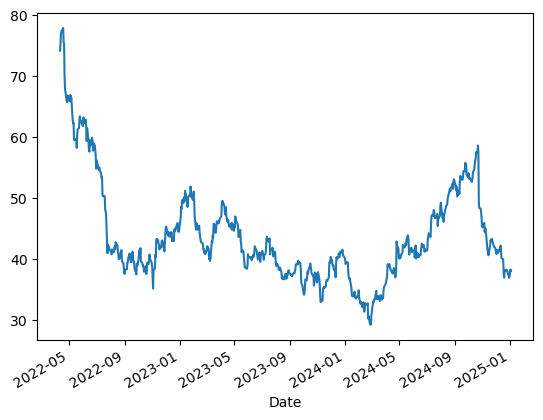

In [5]:
data['Close'].plot()

## 3. Data Preprocessing

In [6]:
print('Null Values =',data.isnull().values.any())

Null Values = False


## 4. Modeling

In [7]:
X=list(data["Close"])
X=[float(x) for x in X]
validation_size = 0.2
#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging


None

In [9]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from IPython.core.debugger import set_trace

class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        #State size depends and is equal to the the window size, n previous days
        self.state_size = state_size # normalized previous days, 
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        #self.epsilon_decay = 0.9
        
        #self.model = self._model()

        self.model = load_model(model_name) if is_eval else self._model()

    #Deep Q Learning model- returns the q-value when given state as input 
    def _model(self):
        model = Sequential()
        #Input Layer
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        #Hidden Layers
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        #Output Layer 
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
        return model
    
    #Return the action on the value function
    #With probability (1-$\epsilon$) choose the action which has the highest Q-value.
    #With probability ($\epsilon$) choose any action at random.
    #Intitially high epsilon-more random, later less
    #The trained agents were evaluated by different initial random condition
    #and an e-greedy policy with epsilon 0.05. This procedure is adopted to minimize the possibility of overfitting during evaluation.
 
    def act(self, state): 
        #If it is test and self.epsilon is still very high, once the epsilon become low, there are no random
        #actions suggested.
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)        
        options = self.model.predict(state, verbose=0)
        #set_trace()
        #action is based on the action that has the highest value from the q-value function.
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        
        # the memory during the training phase. 
        for state, action, reward, next_state, done in mini_batch:
            target = reward # reward or Q at time t    
            #update the Q table based on Q table equation
            #set_trace()
            if not done:
                #set_trace()
                #max of the array of the predicted. 
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])     
                
            # Q-value of the state currently from the table    
            target_f = self.model.predict(state, verbose=0)
            # Update the output Q table for the given action in the table     
            target_f[0][action] = target
            #train and fit the model where state is X and target_f is Y, where the target is updated. 
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [10]:
# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t

def getState(data, t, n):    
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    plt.show()

Running episode 0/10
Buy: $77.36
Sell: $77.95 | Profit: $0.59
Buy: $75.61
Buy: $75.37
Sell: $68.00 | Profit: -$7.61
Buy: $66.26
Sell: $65.82 | Profit: -$9.55
Sell: $66.87 | Profit: $0.61
Buy: $62.44
Sell: $59.73 | Profit: -$2.71
Buy: $61.53
Buy: $62.98
Buy: $63.46
Sell: $61.92 | Profit: $0.38
Buy: $61.89
Sell: $63.29 | Profit: $0.30
Sell: $62.39 | Profit: -$1.06
Buy: $62.43
Sell: $61.80 | Profit: -$0.09
Sell: $59.41 | Profit: -$3.02
Buy: $61.50
Sell: $59.48 | Profit: -$2.02
Buy: $59.41
Sell: $57.83 | Profit: -$1.58
Buy: $59.05
Buy: $58.72
Buy: $57.92
Buy: $57.03
Sell: $54.90 | Profit: -$4.15
Buy: $56.28
Sell: $54.93 | Profit: -$3.79
Sell: $54.69 | Profit: -$3.23
Buy: $55.08
Sell: $54.61 | Profit: -$2.42
Buy: $53.30
Buy: $53.53
Sell: $50.59 | Profit: -$5.69
Buy: $50.35
Buy: $47.28
Sell: $42.45 | Profit: -$12.63
Buy: $41.96
Buy: $42.15
Buy: $41.66
Sell: $41.34 | Profit: -$11.96
Sell: $41.66 | Profit: -$11.88
Buy: $41.19
Buy: $41.20
Buy: $41.68
Buy: $42.08
Sell: $41.68 | Profit: -$8.68
Bu

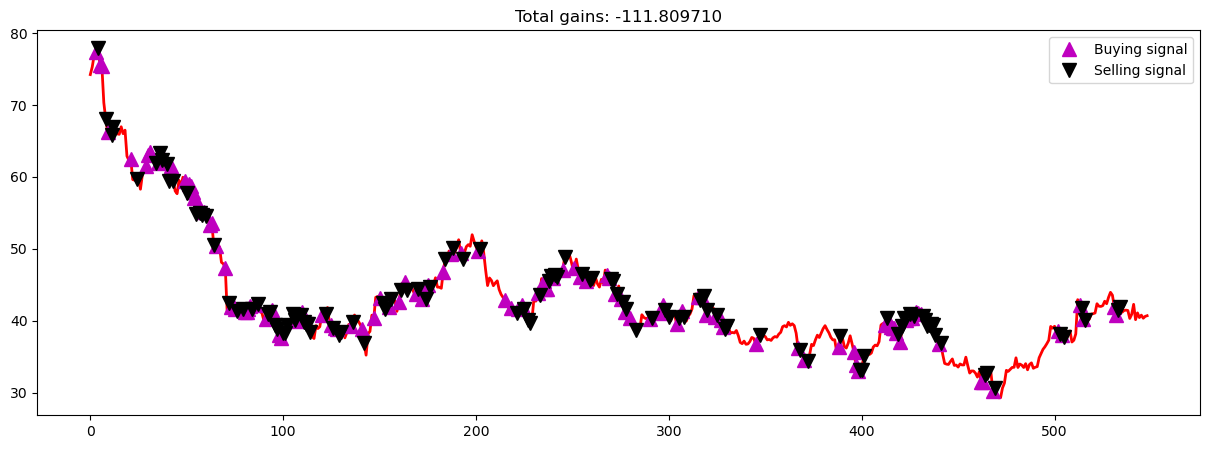

INFO:tensorflow:Assets written to: model_ep0/assets
Running episode 1/10
Buy: $59.63
Buy: $58.29
Sell: $60.33 | Profit: $0.69
Sell: $61.31 | Profit: $3.02
Buy: $62.39
Sell: $62.43 | Profit: $0.04
Buy: $61.80
Buy: $59.41
Sell: $61.50 | Profit: -$0.29
Sell: $59.48 | Profit: $0.06
Buy: $58.04
Buy: $57.67
Buy: $59.53
Buy: $58.66
Sell: $59.96 | Profit: $1.91
Buy: $59.41
Buy: $57.83
Sell: $59.05 | Profit: $1.38
Sell: $58.72 | Profit: -$0.81
Buy: $57.92
Buy: $57.03
Buy: $54.90
Sell: $56.28 | Profit: -$2.38
Buy: $54.93
Sell: $54.69 | Profit: -$4.72
Sell: $55.08 | Profit: -$2.75
Sell: $54.61 | Profit: -$3.31
Sell: $54.09 | Profit: -$2.94
Sell: $53.53 | Profit: -$1.36
Buy: $50.59
Sell: $50.35 | Profit: -$4.58
Sell: $50.43 | Profit: -$0.17


In [ ]:
from IPython.core.debugger import set_trace
window_size = 1
agent = Agent(window_size)
#In this step we feed the closing value of the stock price 
data = X_train
l = len(data) - 1
batch_size = 32
#An episode represents a complete pass over the data.
episode_count = 10

for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)
    #set_trace()
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in range(l):
        action = agent.act(state)    
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            #print("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)      
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            #print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

        done = True if t == l - 1 else False
        #appends the details of the state action etc in the memory, which is used further by the exeReply function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            #set_trace()
            #pd.DataFrame(np.array(agent.memory)).to_csv("Agent"+str(e)+".csv")
            #Chart to show how the model performs with the stock goin up and down for each 
            plot_behavior(data,states_buy, states_sell, total_profit)
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)    
            

    if e % 2 == 0:
        agent.model.save("model_ep" + str(e))

In [ ]:
print(agent.model.summary())


## Alternative Method


In [ ]:
import gym

class StockTradingEnv(gym.Env):
    def __init__(self, data):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.action_space = gym.spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(data.columns),), dtype=np.float32)
    
    def reset(self):
        self.current_step = 0
        return self.data.iloc[self.current_step].values
    
    def step(self, action):
        self.current_step += 1
        done = self.current_step >= len(self.data)
        reward = 0  # Define your reward logic here
        next_state = self.data.iloc[self.current_step].values if not done else None
        return next_state, reward, done, {}

In [ ]:
class QLearningAgent:
    def __init__(self, action_space, observation_space, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.action_space = action_space
        self.observation_space = observation_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((observation_space.shape[0], action_space.n))
    
    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.action_space.sample()
        else:
            return np.argmax(self.q_table[state])
    
    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state, best_next_action]
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.alpha * td_error

In [ ]:
def train_agent(env, agent, episodes=1000):
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state

# Load your stock data
#data = pd.read_csv('stock_data.csv')  # Replace with your dataset

env = StockTradingEnv(data)
agent = QLearningAgent(env.action_space, env.observation_space)
train_agent(env, agent)